# Bike hourly prediction analysis
### Royer Ticse Torres, July 2019


This notebook is a bike utilization analysis in python step-by-step. Starting from raw data to making a hourly prediction model on the [bike sharing](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) dataset.

![title](bike_pic.jpg "Header")

# Dive into data
First things first!. Understand the content of the data

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


from sklearn.externals import joblib
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the hourly data set
address = 'datasets/hour.csv'
df = pd.read_csv(address)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
#Quick Look at the Data Structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


No missing data in our dataset. Let's plot a histogram for each numerical attribute. 

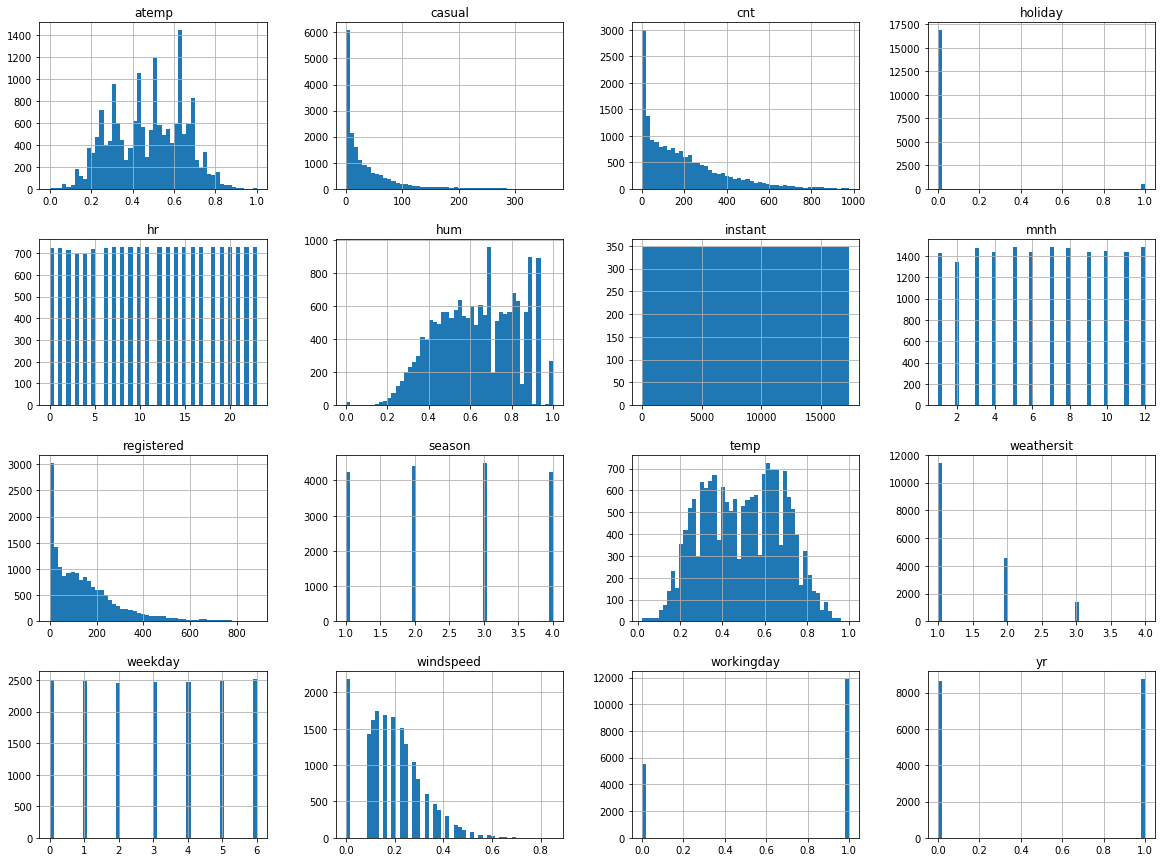

In [4]:
df.hist(bins=50, figsize=(20,15))
#fig = plt.gcf()
#fig.savefig("vars.png")
plt.show()


Let's look at how the count of the hourly rental bikes change as a function of the time

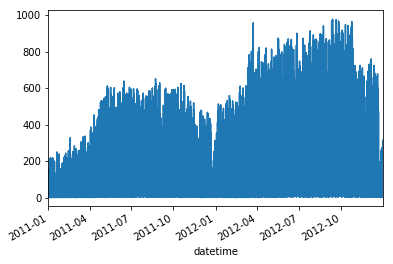

In [5]:
df_time = df.copy()
df_time['datetime'] = pd.to_datetime(df_time['dteday'], format="%Y-%m-%d")
#df['datetime_utc'] = pd.to_datetime(df['datetime'], utc='True')

df_time = df_time.set_index('datetime')

df_time["cnt"].plot()

It's clear an increase for 2012. Let's use the daily count data to investigate further.

In [6]:
# Load the daily data set
address = 'datasets/day.csv'
data = pd.read_csv(address)
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


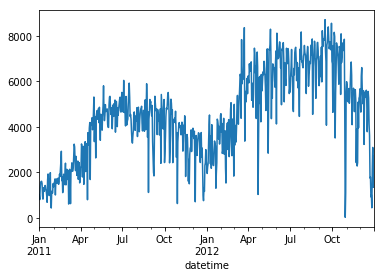

In [7]:
data['datetime'] = pd.to_datetime(data['dteday'], format="%Y-%m-%d")

data = data.set_index('datetime')

data["cnt"].plot()

We can see again an increase of rental bikes for 2012. Let's see the changes for casual or register users as a function of time.

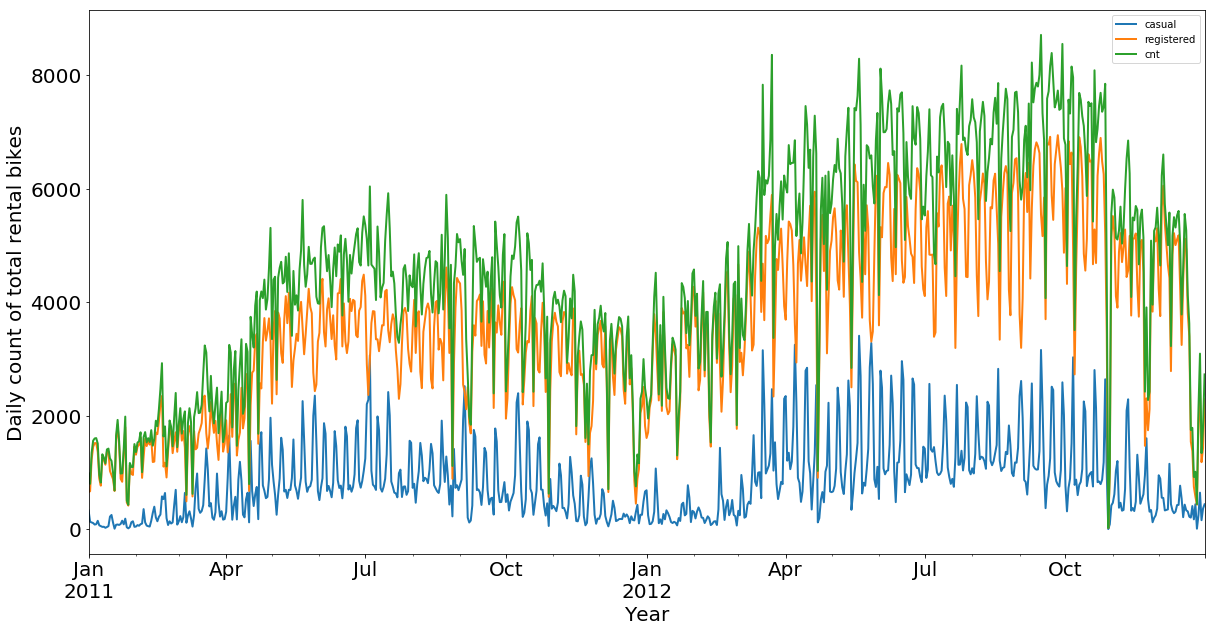

In [8]:
daily_count = data[['casual', 'registered', 'cnt']]

daily_count.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Year', fontsize=20);
plt.ylabel('Daily count of total rental bikes', fontsize=20);
#plt.legend(bbox_to_anchor=(1.2, 0.5))
fig = plt.gcf()
#fig.savefig("year.png", bbox_inches='tight', pad_inches=0.0)


In [9]:
daily_count_2011 = daily_count.loc['2011-01-01':'2011-12-31']
daily_count_2012 = daily_count.loc['2012-01-01':'2012-12-31']

In [10]:
daily_count_2011.describe()

,casual,registered,cnt
count,365.000000,365.000000,365.000000
mean,677.402740,2728.358904,3405.761644
std,556.269121,1060.110413,1378.753666
min,9.000000,416.000000,431.000000
25%,222.000000,1730.000000,2132.000000
50%,614.000000,2915.000000,3740.000000
75%,871.000000,3632.000000,4586.000000
max,3065.000000,4614.000000,6043.000000


In [11]:
daily_count_2012.describe()

,casual,registered,cnt
count,366.000000,366.000000,366.000000
mean,1018.483607,4581.450820,5599.934426
std,758.989897,1424.331846,1788.667868
min,2.000000,20.000000,22.000000
25%,429.750000,3730.500000,4369.000000
50%,904.500000,4776.500000,5927.000000
75%,1262.000000,5663.000000,7011.250000
max,3410.000000,6946.000000,8714.000000


From the tables above we can see an increase of about ~50% for casual users and about ~68% for registered users in 2012.

# Feature Engineering

We need to have variables to send to the machine learning technique and get the predictions. 
Let's do the correlation analysis. During this step we are cheking how features related to each other. 

In [12]:
corrMatt = df[["cnt","temp","atemp","hr","season","mnth","windspeed","workingday","weekday","holiday","weathersit","hum"]].corr()


[Text(0, 0.5, 'cnt'),
 Text(0, 1.5, 'temp'),
 Text(0, 2.5, 'atemp'),
 Text(0, 3.5, 'hr'),
 Text(0, 4.5, 'season'),
 Text(0, 5.5, 'mnth'),
 Text(0, 6.5, 'windspeed'),
 Text(0, 7.5, 'workingday'),
 Text(0, 8.5, 'weekday'),
 Text(0, 9.5, 'holiday'),
 Text(0, 10.5, 'weathersit'),
 Text(0, 11.5, 'hum')]

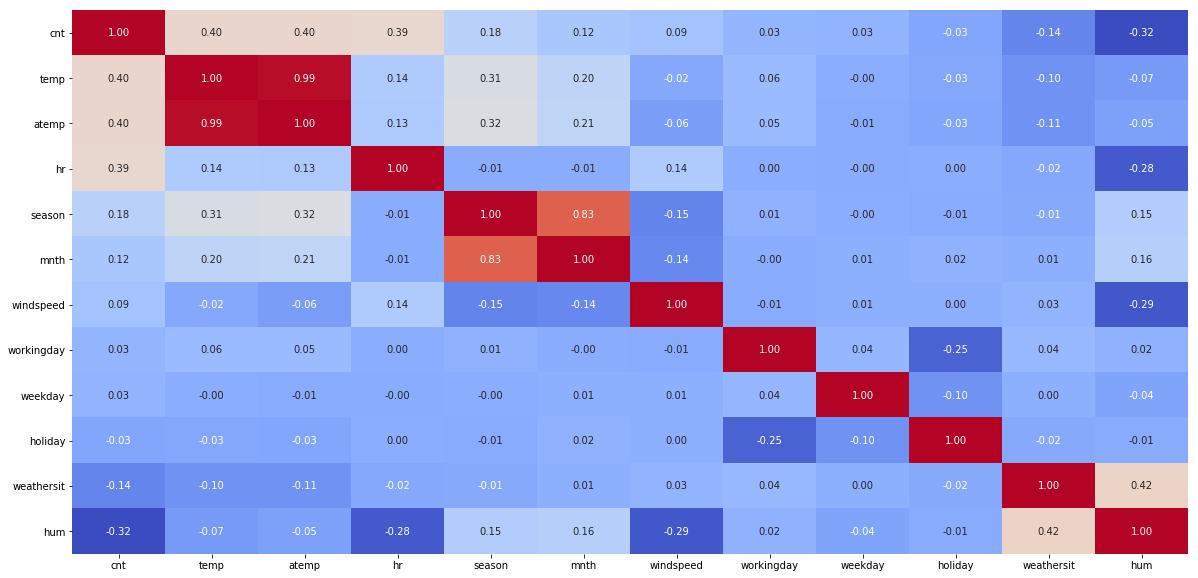

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sb.heatmap(corrMatt, annot=True, fmt='.2f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
#plt.savefig('corr.png', bbox_inches='tight', pad_inches=0.0)


We can see a high correlation between the temperature (temp) and the feeling temperature (atemp). 
Now let’s look at how much each attribute correlates with the total rental bikes

In [14]:
corrMatt["cnt"].sort_values(ascending=False)

cnt           1.000000
temp          0.404772
atemp         0.400929
hr            0.394071
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

The most promising attributes are the temperatures and the hour. I will add the difference between the temperature and the feeling temperature as a new feature.

In [15]:
def adding_feature(df):
    df["dtemp"] = df['temp']-df['atemp']
    
    return df

In [16]:
df = adding_feature(df)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,dtemp
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,-0.0479
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,-0.0527
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,-0.0527
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,-0.0479
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,-0.0479


In [17]:
#Let's look at the correlations
corr_matrix = df.corr()
corr_matrix["cnt"].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
dtemp         0.256288
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

[Text(0, 0.5, 'instant'),
 Text(0, 1.5, 'season'),
 Text(0, 2.5, 'yr'),
 Text(0, 3.5, 'mnth'),
 Text(0, 4.5, 'hr'),
 Text(0, 5.5, 'holiday'),
 Text(0, 6.5, 'weekday'),
 Text(0, 7.5, 'workingday'),
 Text(0, 8.5, 'weathersit'),
 Text(0, 9.5, 'temp'),
 Text(0, 10.5, 'atemp'),
 Text(0, 11.5, 'hum'),
 Text(0, 12.5, 'windspeed'),
 Text(0, 13.5, 'casual'),
 Text(0, 14.5, 'registered'),
 Text(0, 15.5, 'cnt'),
 Text(0, 16.5, 'dtemp')]

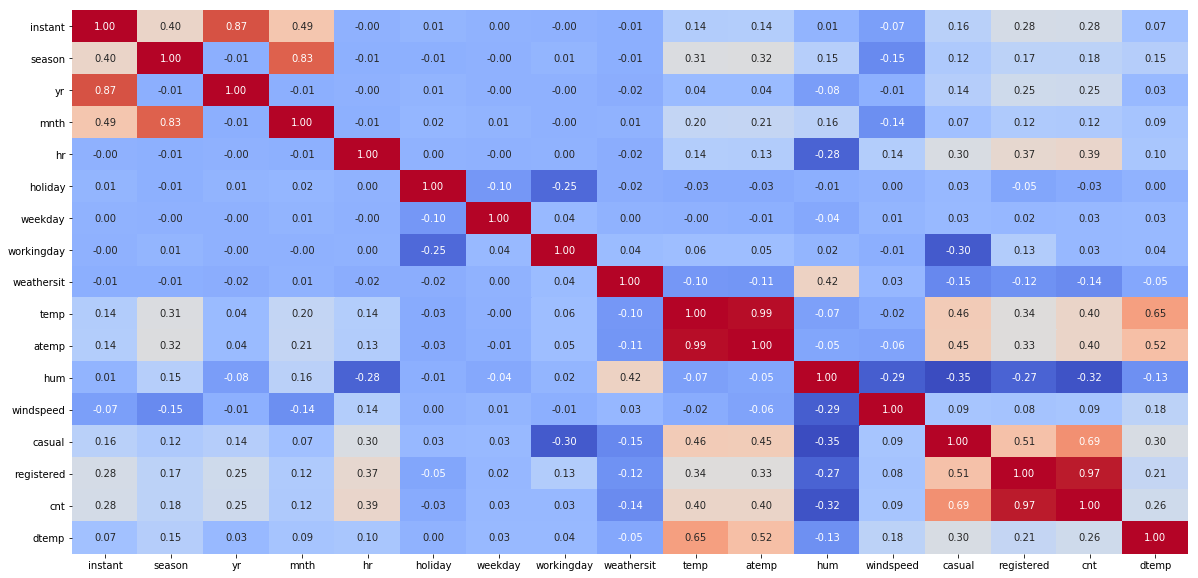

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sb.heatmap(corr_matrix, annot=True, fmt='.2f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
#plt.savefig('corr.png', bbox_inches='tight', pad_inches=0.0)

I will keep the three temperatures as inputs for the machine learning technique.

# Making predictive model

The prediction model is based on Gradient Boosted Trees.

The idea of this model is to train with all the features available. The model would be able to learn the patterns and make a prediction for the count of hourly rental bikes

In [19]:
#preparing the data
X = df.drop(['instant'], axis=1)
X = X.drop(['dteday'], axis=1)
X = X.drop(['yr'], axis=1)
X = X.drop(['registered'], axis=1)
X = X.drop(['casual'], axis=1)
X = X.drop(['cnt'], axis=1)
y =df['cnt'].values 

In [20]:
# split the data in training set (90%) and test set (10%).

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [21]:
# Fit regression model
model = GradientBoostingRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    loss='lad'
)

In [22]:
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
# Save the trained model to a file so we can use it later
joblib.dump(model, 'trained_GBR_regresion_model.pkl')

['trained_GBR_regresion_model.pkl']

In [24]:
# Find the error rate on the traing set
mae = mean_absolute_error(y_train, model.predict(X_train))
print("Training Set Mean Absolute Error: %.4f" % mae)

Training Set Mean Absolute Error: 42.4996


Let's use cross-validation for training and evaluating in the training data set.

In [25]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


In [26]:
from sklearn.model_selection import cross_val_score

GBR_scores = cross_val_score(model, X_train, y_train,
                             scoring='neg_mean_absolute_error',cv=5)
GBR_mae_scores = -GBR_scores
display_scores(GBR_mae_scores)

Scores: [47.15132868 47.20900043 45.93253157 46.60569555 45.93847945]
Mean: 46.567407135403705
Standard deviation: 0.5572592502851791


Note that the score on the training set is a bit lower than on the validation sets. 
This difference gives us the idea of the overfitting of the model in the training data set.

Now let's print the feature importance ranking from the model.

In [27]:
# These are the feature labels from our data set
feature_labels = np.array(['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit',
                           'temp','atemp', 'hum', 'windspeed', 'dtemp'])

In [28]:
importance = model.feature_importances_

feauture_indexes_by_importance = importance.argsort()

for index in feauture_indexes_by_importance:
    print("{} - {:.2f}%".format(feature_labels[index], (importance[index] * 100.0)))

holiday - 0.33%
windspeed - 1.40%
weathersit - 1.81%
mnth - 1.85%
dtemp - 2.33%
season - 2.39%
weekday - 2.87%
hum - 3.67%
atemp - 6.12%
workingday - 7.28%
temp - 8.93%
hr - 61.02%


# Make predictions

In [29]:
# Load the model we trained previously
GBR_model = joblib.load('trained_GBR_regresion_model.pkl')

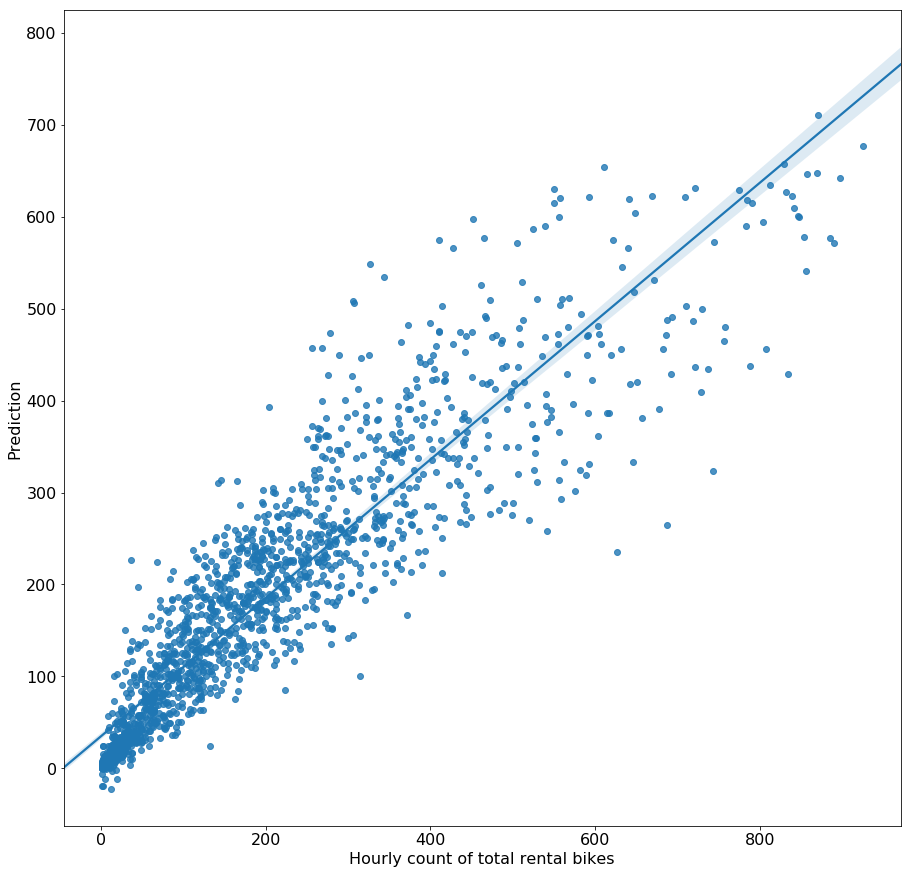

In [30]:
# Runing the model and making a prediction in the test data set
pred = GBR_model.predict(X_test)

fig, ax = plt.subplots()
fig.set_size_inches(15,15)
b =sb.regplot(y_test, np.round(pred), scatter=True)
#ax.set(xlabel='Hourly count of total rental bikes', ylabel='Prediction')
b.set_xlabel("Hourly count of total rental bikes",fontsize=16)
b.set_ylabel("Prediction",fontsize=16)
b.tick_params(labelsize=16)
#plt.savefig('predictions.png', bbox_inches='tight', pad_inches=0.0)


In [31]:
mae = mean_absolute_error(y_test, GBR_model.predict(X_test))
print("Test Set Mean Absolute Error: %.4f" % mae)

Test Set Mean Absolute Error: 47.0177
